In [1]:
import sys, os
sys.path.append(os.path.abspath("..")) 

from src.insurer_model import Insurer

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
irp_merged = pd.read_csv('../data/processed/irp_merged.csv')
bond_yields = pd.read_csv("../data/processed/bond_yields_merged.csv")

irp_merged["date"] = pd.to_datetime(irp_merged["date"]).dt.normalize()
irp_merged = irp_merged.set_index("date").sort_index()

bond_yields["date"] = pd.to_datetime(bond_yields["date"]).dt.normalize()
bond_yields = bond_yields.set_index("date").sort_index()

df_data = pd.merge(bond_yields, irp_merged, on='date', how='inner')


## Simulation 1: General Hedge Ratio & forward dates simulations

In [3]:
def create_insurer(name, hedge_ratio):
    initial_date = df_data.index[0]
    initial_spot = df_data.loc[initial_date, 'spot']
    initial_us_yield = df_data.loc[initial_date, 'yield_10Y']
    
    return Insurer(
        name=name,
        total_assets_twd=10e12,
        foreign_asset_ratio=0.70,
        usd_denom_ratio=0.90,
        initial_twd_usd_spot=initial_spot,
        initial_us_bond_yield=initial_us_yield,
        initial_twd_equity=2.5e12,
        initial_fevr_balance=220e9,
        bond_duration=10,
        hedge_ratio=hedge_ratio
    )

In [14]:
def run_simulation(insurer, df_data, forward_col, tenor_length_months):
    previous_twd_usd_spot = df_data.iloc[0]['spot']
    previous_us_bond_yield = df_data.iloc[0]['yield_10Y']
    
    for index, row in df_data.iterrows():
        current_twd_usd_spot = row['spot']
        current_us_bond_yield = row['yield_10Y']
        
        forward_rate = row.get(forward_col, current_twd_usd_spot) 
        
        insurer.simulate_day(
            date=index,
            current_twd_usd_spot=current_twd_usd_spot,
            previous_twd_usd_spot=previous_twd_usd_spot,
            current_us_bond_yield=current_us_bond_yield,
            previous_us_bond_yield=previous_us_bond_yield,
            forward_rate = forward_rate,
            tenor_length_months=tenor_length_months
        )
        previous_twd_usd_spot = current_twd_usd_spot
        previous_us_bond_yield = current_us_bond_yield
        
    return insurer.history


## Running the simulatio non normal period (pre 2025 when the sharp appreciation event occurered)

/Users/patrickwu/Documents/Cornell/taiwan-insurer-fx-hedging-model/src/insurer_model.py:174: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.history = pd.concat([self.history, pd.DataFrame([{
/Users/patrickwu/Documents/Cornell/taiwan-insurer-fx-hedging-model/src/insurer_model.py:174: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.history = pd.concat([self.history, pd.DataFrame([{
/Users/patrickwu/Documents/Cornell/taiwan-insurer-fx-hedging-model/src/insurer_model.py:174: FutureWarning: Th

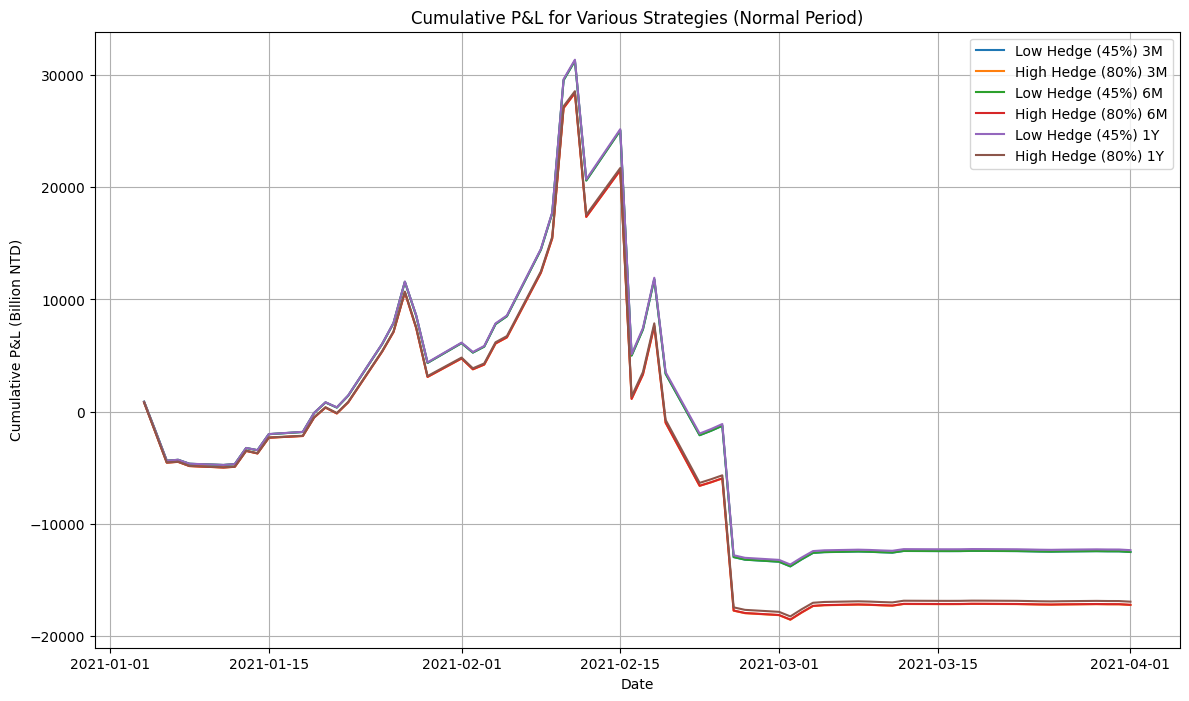

In [16]:

df_normal = df_data.loc['2021-01-04':'2025-01-01'].copy()

# 2.2 Define and Run Strategies to Compare
strategies = {
    'Low Hedge (45%) 3M': {'hedge_ratio': 0.45, 'forward_col': 'forward_3m', 'tenor': 3},
    'High Hedge (80%) 3M': {'hedge_ratio': 0.80, 'forward_col': 'forward_3m', 'tenor': 3},
    'Low Hedge (45%) 6M': {'hedge_ratio': 0.45, 'forward_col': 'forward_6m', 'tenor': 6},
    'High Hedge (80%) 6M': {'hedge_ratio': 0.80, 'forward_col': 'forward_6m', 'tenor': 6},
    'Low Hedge (45%) 1Y': {'hedge_ratio': 0.45, 'forward_col': 'forward_3m', 'tenor': 12},
    'High Hedge (80%) 1Y': {'hedge_ratio': 0.80, 'forward_col': 'forward_3m', 'tenor': 12},

    #'No Hedge (0%)': {'hedge_ratio': 0.0, 'forward_col': None, 'tenor': 0}
}

normal_results = {}
for name, params in strategies.items():
    if params['forward_col'] is not None: ## for hedge scenerios
        insurer_model = create_insurer(name, params['hedge_ratio'])
        history = run_simulation(insurer_model, df_normal, params['forward_col'], params['tenor'])
        normal_results[name] = history
    else:
        # Special case for no hedge, as the forward rate column is irrelevant
        insurer_model = create_insurer(name, params['hedge_ratio'])
        # Pass a placeholder to forward_rate and tenor
        history = run_simulation(insurer_model, df_normal, 'spot', params['tenor'])
        normal_results[name] = history

# 2.3 Visualize P&L over the Normal Period
plt.figure(figsize=(14, 8))
for name, history in normal_results.items():
    pnl = history['Net_FX_Impact'] + history['Investment_Income_TWD']
    plt.plot(history['Date'], pnl.cumsum() / 1e9, label=name)

plt.title('Cumulative P&L for Various Strategies (Normal Period)')
plt.xlabel('Date')
plt.ylabel('Cumulative P&L (Billion NTD)')
plt.legend()
plt.grid(True)
plt.show()

/Users/patrickwu/Documents/Cornell/taiwan-insurer-fx-hedging-model/src/insurer_model.py:174: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.history = pd.concat([self.history, pd.DataFrame([{
/Users/patrickwu/Documents/Cornell/taiwan-insurer-fx-hedging-model/src/insurer_model.py:174: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.history = pd.concat([self.history, pd.DataFrame([{
/Users/patrickwu/Documents/Cornell/taiwan-insurer-fx-hedging-model/src/insurer_model.py:174: FutureWarning: Th

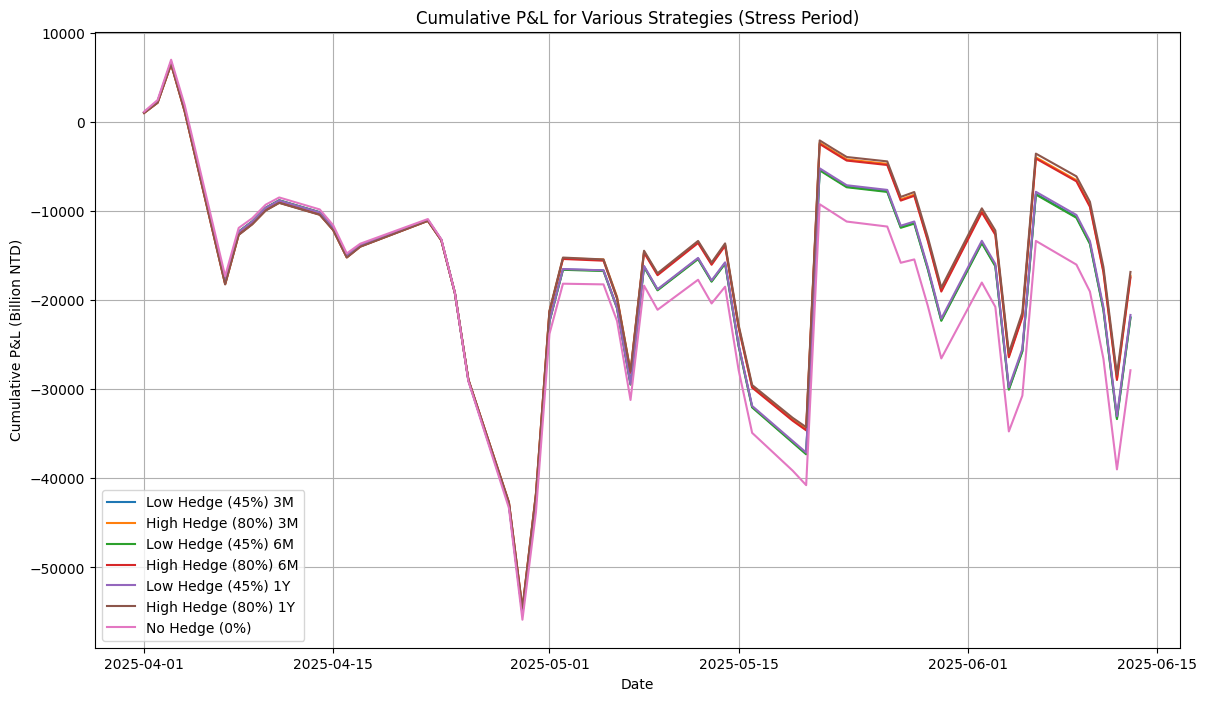

In [13]:

df_stress = df_data.loc['2025-04-01':'2025-06-15'].copy()

# 2.3 Define and Run Strategies to Compare

stress_results = {}
for name, params in strategies.items():
    if params['forward_col'] is not None: ## for hedge scenerios
        insurer_model = create_insurer(name, params['hedge_ratio'])
        history = run_simulation(insurer_model, df_normal, params['forward_col'], params['tenor'])
        normal_results[name] = history
    else:
        # Special case for no hedge, as the forward rate column is irrelevant
        insurer_model = create_insurer(name, params['hedge_ratio'])
        # Pass a placeholder to forward_rate and tenor
        history = run_simulation(insurer_model, df_normal, 'spot', params['tenor'])
        normal_results[name] = history

# 2.3 Visualize P&L over the Normal Period
plt.figure(figsize=(14, 8))
for name, history in normal_results.items():
    pnl = history['Net_FX_Impact'] + history['Investment_Income_TWD']
    plt.plot(history['Date'], pnl.cumsum() / 1e9, label=name)

plt.title('Cumulative P&L for Various Strategies (Stress Period)')
plt.xlabel('Date')
plt.ylabel('Cumulative P&L (Billion NTD)')
plt.legend()
plt.grid(True)
plt.show()

DUring Stress periods the no hedge positions show a lower PnL returns which makes snese under the volitiy and how hedging fundamentally functions

In [9]:
## Running pre-2025 
initial_date = "2021-01-04"

initial_spot = irp_merged.at[pd.Timestamp(initial_date), "spot"]

initial_us_yield = bond_yields.at[pd.Timestamp(initial_date), 'yield_10Y']
initial_equity_twd = 2.5e12 # NT$2.5 trillion, a representative figure

def make_insurer(initial_spot, initial_yield):
    insurer = Insurer(
        name= "Placeholder",
        total_assets_twd= 10e12,
        foreign_asset_ratio=0.70,
        usd_denom_ratio =0.90,
        initial_twd_usd_spot= initial_spot,
        initial_us_bond_yield=initial_us_yield,
        initial_twd_equity=initial_equity_twd,
        bond_duration=10,
        hedge_ratio=0.45
    )
    return insurer

0.45
